In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [19]:
train_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"
test_url  = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2025-26/gws/merged_gw.csv"

train_df = pd.read_csv(train_url, on_bad_lines='skip', engine='python')
test_df  = pd.read_csv(test_url, on_bad_lines='skip', engine='python')

print("Datasets Loaded Successfully")
print(f"Training Data Shape: {train_df.shape}")
print(f"Testing Data Shape: {test_df.shape}")

Datasets Loaded Successfully
Training Data Shape: (29725, 41)
Testing Data Shape: (5821, 46)


In [22]:
train_df.columns = [c.lower().replace(" ", "_") for c in train_df.columns]
test_df.columns  = [c.lower().replace(" ", "_") for c in test_df.columns]

if 'name' not in train_df.columns and {'first_name', 'second_name'}.issubset(train_df.columns):
    train_df['name'] = train_df['first_name'] + " " + train_df['second_name']
if 'name' not in test_df.columns and {'first_name', 'second_name'}.issubset(test_df.columns):
    test_df['name'] = test_df['first_name'] + " " + test_df['second_name']

required_cols = ['name', 'team', 'round', 'total_points']
for col in required_cols:
    if col not in train_df.columns or col not in test_df.columns:
        raise ValueError(f" Missing required column: {col}")

train_df = train_df.sort_values(by=['name', 'round'])
test_df  = test_df.sort_values(by=['name', 'round'])

In [23]:
base_features = [
    'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
    'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
    'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
    'threat', 'ict_index', 'value'
]

train_df = train_df.dropna(subset=base_features + ['total_points'])
test_df  = test_df.dropna(subset=base_features + ['total_points'])

print(f" Cleaned Train Data: {train_df.shape}")
print(f" Cleaned Test Data: {test_df.shape}")

 Cleaned Train Data: (29725, 41)
 Cleaned Test Data: (5821, 46)


In [24]:
rolling_data = []
for player in test_df['name'].unique():
    player_df = test_df[test_df['name'] == player].sort_values('round')
    if len(player_df) < 5:
        continue

    prev_window = player_df.tail(5)
    features_dict = {f'avg_{f}': prev_window[f].mean() for f in base_features}
    features_dict.update({
        'name': player,
        'team': prev_window['team'].values[-1],
        'current_round': int(prev_window['round'].values[-1]),
        'avg_points_last_5_gws': round(prev_window['total_points'].mean(), 2)
    })
    rolling_data.append(features_dict)

rolling_df = pd.DataFrame(rolling_data)
print(f" Built rolling dataset for 2025–26 players: {rolling_df.shape}")

 Built rolling dataset for 2025–26 players: (740, 22)


In [26]:
X_train = train_df[base_features]
y_train = train_df['total_points']

X_test = rolling_df[[f'avg_{f}' for f in base_features if f'avg_{f}' in rolling_df.columns]].copy()
X_test.columns = [c.replace('avg_', '') for c in X_test.columns]
X_test = X_test[X_train.columns]

In [27]:
models = {
    "Linear Regression": (LinearRegression(), {
        "fit_intercept": [True, False],
        "positive": [True, False]
    }),
    "Lasso Regression": (Lasso(max_iter=10000), {
        "alpha": [0.001, 0.01, 0.1, 1.0, 5.0],
        "fit_intercept": [True, False]
    }),
    "Random Forest": (RandomForestRegressor(random_state=42, n_jobs=-1), {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5]
    })
}

results = []
best_models = {}

print("\n Performing Grid Search for Linear, Lasso, and Random Forest...")

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV R²": grid.best_score_
    })
    print(f"{name} Best R²: {grid.best_score_:.4f} with params: {grid.best_params_}")


 Performing Grid Search for Linear, Lasso, and Random Forest...
Linear Regression Best R²: 0.9531 with params: {'fit_intercept': False, 'positive': False}
Lasso Regression Best R²: 0.9518 with params: {'alpha': 0.001, 'fit_intercept': False}
Random Forest Best R²: 0.9808 with params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
print("\n Evaluating Models on Validation Split...")
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

metrics = []
for name, model in best_models.items():
    model.fit(X_t, y_t)
    y_pred = model.predict(X_v)
    mae = mean_absolute_error(y_v, y_pred)
    r2 = r2_score(y_v, y_pred)
    metrics.append({"Model": name, "MAE": mae, "R²": r2})
    print(f"{name}: MAE = {mae:.3f}, R² = {r2:.3f}")

metrics_df = pd.DataFrame(metrics)
display(metrics_df)


 Evaluating Models on Validation Split...
Linear Regression: MAE = 0.285, R² = 0.954


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e+01, tolerance: 1.510e+01
  model = cd_fast.enet_coordinate_descent(


Lasso Regression: MAE = 0.291, R² = 0.951
Random Forest: MAE = 0.078, R² = 0.981


,Model,MAE,R²
0,Linear Regression,0.285116,0.953743
1,Lasso Regression,0.291112,0.950525
2,Random Forest,0.077933,0.980730


In [29]:
best_model_name = metrics_df.sort_values("R²", ascending=False).iloc[0]["Model"]
best_model = best_models[best_model_name]
print(f"\n Best Model Selected: {best_model_name}")

rolling_df['predicted_points_next_gw'] = best_model.predict(X_test)
pred_df = rolling_df.sort_values('predicted_points_next_gw', ascending=False)

print("\n Top 10 Predicted Performers for Next Gameweek:")
display(pred_df[['name', 'team', 'current_round', 'predicted_points_next_gw', 'avg_points_last_5_gws']].head(10))


 Best Model Selected: Random Forest

 Top 10 Predicted Performers for Next Gameweek:


,name,team,current_round,predicted_points_next_gw,avg_points_last_5_gws
203,Erling Haaland,Man City,9,13.32,10.6
235,Gabriel dos Santos Magalhães,Arsenal,9,8.33,9.0
606,Robin Roefs,Sunderland,9,7.91,6.6
538,Nick Woltemade,Newcastle,9,7.66,5.6
507,Micky van de Ven,Spurs,9,7.35,8.0
273,Igor Thiago Nascimento Rodrigues,Brentford,9,7.19,5.8
327,Jean-Philippe Mateta,Crystal Palace,9,7.13,5.8
95,Bryan Mbeumo,Man Utd,9,7.01,6.2
476,Martín Zubimendi Ibáñez,Arsenal,9,7.00,5.6
551,Nordi Mukiele,Sunderland,9,7.00,7.8


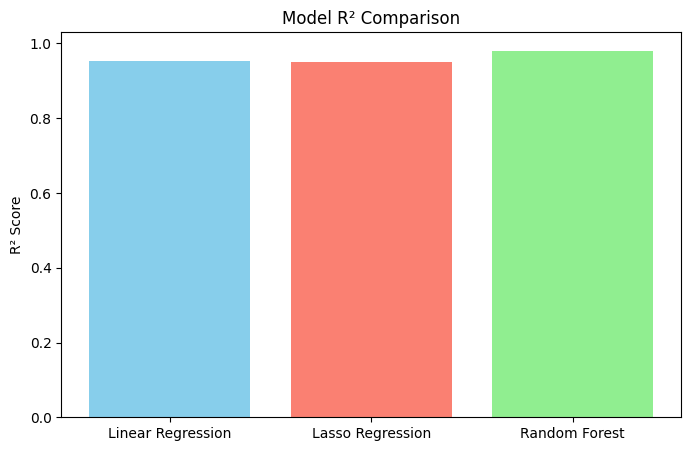

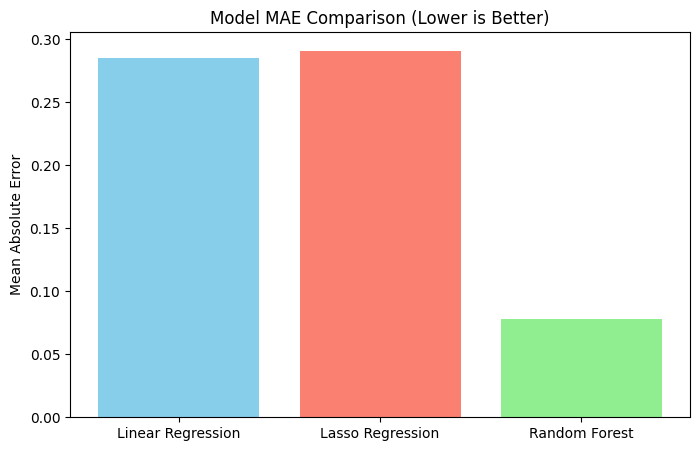

In [30]:
plt.figure(figsize=(8,5))
plt.bar(metrics_df["Model"], metrics_df["R²"], color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Model R² Comparison")
plt.ylabel("R² Score")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(metrics_df["Model"], metrics_df["MAE"], color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Model MAE Comparison (Lower is Better)")
plt.ylabel("Mean Absolute Error")
plt.show()

In [31]:
def predict_next_gw_for_player(player_name):
    """
    Displays predicted next GW points for a specific player from 2025–26.
    """
    player_pred = pred_df[pred_df['name'].str.contains(player_name, case=False, na=False)]
    if player_pred.empty:
        print(f" Player '{player_name}' not found.")
        return
    print(f"\n---  Next Gameweek Prediction ({best_model_name}) for '{player_name}' ---")
    display(player_pred[['name', 'team', 'current_round', 'predicted_points_next_gw', 'avg_points_last_5_gws']])

#Example
predict_next_gw_for_player("Erling Haaland")


---  Next Gameweek Prediction (Random Forest) for 'Erling Haaland' ---


,name,team,current_round,predicted_points_next_gw,avg_points_last_5_gws
203,Erling Haaland,Man City,9,13.32,10.6
